In [1]:
import tensorflow as tf
print(tf.__version__)

0.11.0


In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
#from tensorflow.nn.rnn import *
from tensorflow.python.ops  import *

%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.python.framework import dtypes

import seaborn as sns

In [4]:
cd /

/


In [5]:
cd Users/Seychelles/Desktop/GoogleTensorflow/Data_Collector/CSV_file_from_2007_to_2017/

/Users/Seychelles/Desktop/GoogleTensorflow/Data_Collector/CSV_file_from_2007_to_2017


In [6]:
DataKarpos = pd.read_csv('Target.csv') # Only Karpos Location is used here . Other locations are zero

In [7]:
DataKarpos[1:2]

,Unnamed: 0,date,PM10,NAME,PM10_null_pointers,CO,CO_null_pointers,NO2,NO2_null_pointers,O3,...,daysInterval,days_interval,hour_interval,Centar,Gazi Baba,Karpos,Lisice,Miladinovci,Mrsevci,Rektorat
1,10,2007-01-02 00:00:00,0.950396,Karpos,1,0.33293,1,NaN,0,-0.094688,...,0 days 00:00:00.000000000,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [8]:
TargetKarpos = DataKarpos[['PM10']].copy(deep=True) # copy PM10 data out from data sets

# Analysis Of Misiing Values

In [9]:
Target = DataKarpos[['PM10']].copy(deep=True)

In [10]:
Target.shape

(89500, 1)

In [11]:
null_data_PM10 = Target[Target.isnull().any(axis=1)] # extract data sets with null values

In [12]:
null_data_PM10.to_csv("PM10_NUll.txt")# save to file

In [13]:
Target.to_csv("R_target.csv")# save to file

In [14]:
null_data_PM10.head()

,PM10
168,NaN
169,NaN
170,NaN
171,NaN
172,NaN


In [15]:
def getPctMissing(series):
    '''
    Returns percentage of Missing data in a data set.
    Input : Pandas series
    Output: Percentage of missing data in data set
    '''
    num = series.isnull().sum()
    Total_data = len(series)
    return 100*(num/Total_data)

In [16]:
print("Number of null values in PM10 : ");Target.isnull().sum()

Number of null values in PM10 : 


PM10    28871
dtype: int64

In [17]:
print("Number of non null values in PM10 : ");Target.count()

Number of non null values in PM10 : 


PM10    60629
dtype: int64

In [18]:
print("Percentage of Missing Value: "); getPctMissing(Target)

Percentage of Missing Value: 


PM10    32.258101
dtype: float64

# Fill Missing Values With Nan

In [19]:
pwd

'/Users/Seychelles/Desktop/GoogleTensorflow/Data_Collector/CSV_file_from_2007_to_2017'

In [20]:
Target.fillna(0,inplace=True) # Fill Missing value with 0. Default model

In [21]:
Target_list = Target.values.tolist() # create a list of values for use in data model

# Prepare Data 

In [22]:
counter=0
def dataGetter(datalist):
    """
    Returns a single PM10 value.
    Input: PM10 Data list named Target_list above
    Output: single PM10 value
    """
    global counter;
    assert type(datalist) == list;
    
    
    value = datalist[counter]
    #print(counter)


    counter = counter +1
             
    return np.array([value])

In [23]:
# Define window size or learning
sliding_window = []
lag=25 # 24 hours time step from 0 to 24 plus the window_step_move (25) which is to be predicted
window_move_step = 1
for i in range(lag - window_move_step):
    sliding_window.append(dataGetter(Target_list))

In [24]:
len(sliding_window)

24

In [25]:
def get_pair(Target):
    """
    Returns an (current, target) 
    Target is lag steps 24 ahead of current
    """
 
    global sliding_window
    sliding_window.append(dataGetter(Target))
    #print(len(sliding_window))
    
    input_value = sliding_window[0:24]
    
    input_value=np.array(input_value)
    #print(input_value.shape)
    input_value=np.reshape(input_value,(1,24))
    ##print(input_value)
    output_value = sliding_window[-1]
    ##print(output_value)
    sliding_window = sliding_window[1:]
    #print(len(sliding_window))
    return input_value, output_value

In [26]:
len(sliding_window)

24

#Input Params
input_dim = 1
 
#To maintain state
last_value = np.array([0 for i in range(input_dim)])
last_derivative = np.array([0 for i in range(input_dim)])
 
def get_total_input_output(Target):
    """
    Get Total feed vector - input and output 
    """
    global last_value, last_derivative
    raw_i, raw_o = get_pair(Target)
    raw_i = raw_i[0]
    l1 = list(raw_i)
    derivative = raw_i - last_value
    l2 = list(derivative)
    last_value = raw_i
    l3 = list(derivative - last_derivative)
    last_derivative = derivative
    return np.array([l1 + l2 + l3]), raw_o

# Build Model

In [27]:
#Imports
import tensorflow as tf
#from tensorflow.nn.rnn import *
from tensorflow.python.ops  import *


In [28]:
#Input Params
with tf.name_scope("input_target_placeholders"):    
    input_dim = 1
    ##The Input Layer as a Placeholder
    #Since we will provide data sequentially, the 'batch size'
    #is 1.
    input_layer = tf.placeholder(tf.float32, [1, input_dim*24],name="input_data")
    correct_output = tf.placeholder(tf.float32, [1, input_dim],name="target_data")

In [29]:
###inistate = tf.Variable(lstm_cell_with_dropout.zero_state(BATCH_SIZE, tf.float32), trainable=False)

In [30]:
with tf.name_scope("lstmLayer"):    
    lstm_layer1 = rnn_cell.BasicLSTMCell(input_dim*24,state_is_tuple=False)
    #The LSTM state as a Variable initialized to zeroes
    lstm_state1 = tf.Variable(tf.zeros([1, lstm_layer1.state_size]),trainable=False,name="initial_state")
    #lstm_state1 = tf.Variable(lstm_layer1.zero_state(1,lstm_layer1.state_size[-1] ), trainable=False)
    #Connect the input layer and initial LSTM state to the LSTM cell
    lstm_output1, lstm_state_output1 = lstm_layer1(input_layer, lstm_state1)
    #The LSTM state will get updated
    lstm_update_op1 = lstm_state1.assign(lstm_state_output1)

In [31]:
lstm_output1.get_shape() # verify shape

TensorShape([Dimension(1), Dimension(24)])

In [32]:
with tf.name_scope("weight_Bias_learning_rate"):
    global_step = tf.Variable(0, trainable=False,name="global_step")
    starter_learning_rate = 0.007
    learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           1000, 0.1, staircase=False,name ="Exponential_decay")
    ##The Regression-Output Layer
    #The Weights and Biases matrices first
    output_W1 = tf.Variable(tf.truncated_normal([input_dim*24, input_dim]),name="weight")
    output_b1 = tf.Variable(tf.zeros([input_dim]),name="bias")
    

In [33]:
with tf.name_scope("prediction"):
    #Compute the output
    final_output = tf.matmul(lstm_output1, output_W1) + output_b1

In [34]:
final_output.get_shape() # verify output shape

TensorShape([Dimension(1), Dimension(1)])

In [35]:
output_W1 # verify weight shape

In [42]:
with tf.name_scope("RMS_error"):
    ##Calculate the Sum-of-Squares Error
    error = tf.pow(tf.sub(final_output, correct_output), 2)

In [43]:
#error = tf.reshape(error,(1,))

In [44]:
with tf.name_scope("optimizer"):
    ##The Optimizer
    #Adam works best
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(error)

In [45]:
# Create a summary to monitor MSE
mse=tf.summary.tensor_summary("errors_Summary",error)
# Create a summary to monitor  predictions
prediction=tf.summary.tensor_summary("predictions_Summmary", final_output)
# Create a summary to monitor bias
bias_vec=tf.summary.tensor_summary("bias", output_b1)
# create sumary
#rate_vec=tf.summary.scalar("rate", learning_rate)


#histogram plot

error_stats=tf.histogram_summary("errors_Histogram",error)
weight_stats=tf.histogram_summary("weights_Histogram",output_W1)
bias_stats=tf.histogram_summary("biases_Histogram",output_b1)
#learning_stats=tf.histogram_summary("biases_Histogram",learning_rate)


#merged_summary_op =  tf.merge_all_summaries()
merged_summary_op =   tf.merge_summary([mse,prediction,bias_vec,error_stats,weight_stats,bias_stats])

In [46]:
##Session
sess = tf.Session()
#Initialize all Variables
#sess.run(tf.initialize_all_variables())


In [47]:
len(Target_list)

89500

# Evaluation Data set

In [48]:
logs_path = '/Users/Seychelles/Desktop/GoogleTensorflow/finals/tensorboardData/sliding_window/'

In [49]:
##Training Parameters
n_iter = 80000 
inner_iter = 8000
actual_output1 = []
network_output1 = []
validation_prediction=[];
validation_target =[];
lower_bound=0;
upper_bound=800;
prediction_window=800

In [50]:
import copy
#new_list = copy.deepcopy(old_list)
Test_eval=copy.deepcopy(Target_list[80001:])

In [51]:
len(Test_eval)

9499

In [52]:
len(Target_list)-80000

9500

In [53]:
# We have 800000 iterations
# Between itertions and every 10000 steps we make all initial_state = 0 and perform cross-validate
# We have 80000 validation set
# We test with the remainder 
Remainder = len(Test_eval) - (n_iter/inner_iter*prediction_window)

In [54]:
Remainder = int(Remainder)

In [55]:
Remainder

1499

In [56]:
init = tf.initialize_all_variables()
error_=[]
with tf.Session() as sess:
    sess.run(init)


    writer = tf.train.SummaryWriter(logs_path, graph= tf.get_default_graph()) 

    counter =0 
    assert counter==0

    for i in range(n_iter):
        input_v, output_v = get_pair(Target_list)
        _, _, network_output,errors,summary = sess.run([lstm_update_op1,
                                     train_step,
                                     final_output,error,merged_summary_op],
                                    feed_dict = {
                                        input_layer: input_v,
                                        correct_output: output_v})
        writer.add_summary(summary)
        error_.append(errors)
        if i%inner_iter==0 & i!=0:
            assert i!=0;
            sess.run(lstm_state1.assign(tf.zeros([1, lstm_layer1.state_size])))
        
            for j in range(len(Test_eval[lower_bound:upper_bound])):
                input_val, output_val = get_pair(Test2)
                _, network_output = sess.run([lstm_update_op1,
                                      final_output],
                                     feed_dict = {
                                     input_layer: input_val,
                                     correct_output: output_val})
                lower_bound= lower_bound+prediction_window;
                upper_bound = upper_bound + prediction_window;
                validation_target.append(output_val)
                validation_prediction.append(network_output1)
        #sess.run(lstm_state1.assign(tf.zeros([1, lstm_layer1.state_size])))

        actual_output1.append(output_v)
        #actual_output2.append(output_v[0][1])
        network_output1.append(network_output)
        #network_output2.append(network_output[0][1])
        #x_axis.append(i)
                
        
 


# Errors Plot

In [59]:
errorplot = np.array(error_)

In [72]:
errorplot = errorplot.reshape(80000,1)

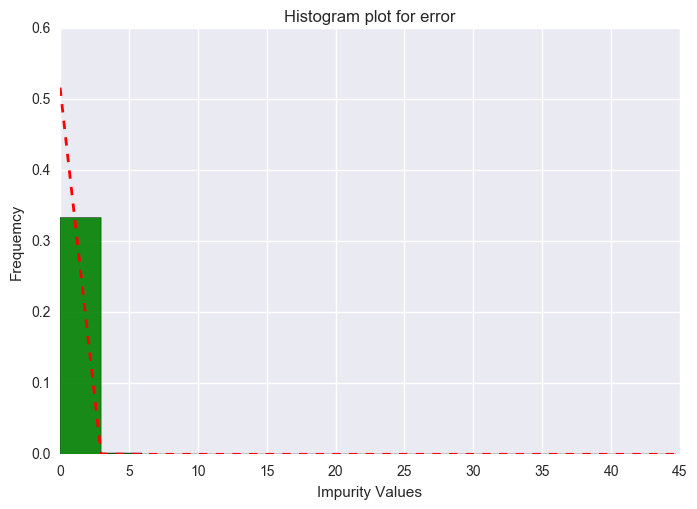

In [130]:
import matplotlib.mlab as mlab

#fig, ax = plt.subplots()
n, bins, patches=plt.hist(errorplot,15,normed=1,facecolor='green',alpha=0.9)
mu= np.mean(errorplot);sigma=np.std(errorplot);
y = mlab.normpdf( bins,mu,sigma)
#y = mlab.normpdf( bins, mu, sigma)
plt.plot(bins, y, 'r--', linewidth=2)
#ax.set_yscale('log')
#ax.set_xscale('log')
plt.title("Histogram plot for error")
plt.ylabel("Frequemcy")
plt.xlabel("Impurity Values")
plt.show()

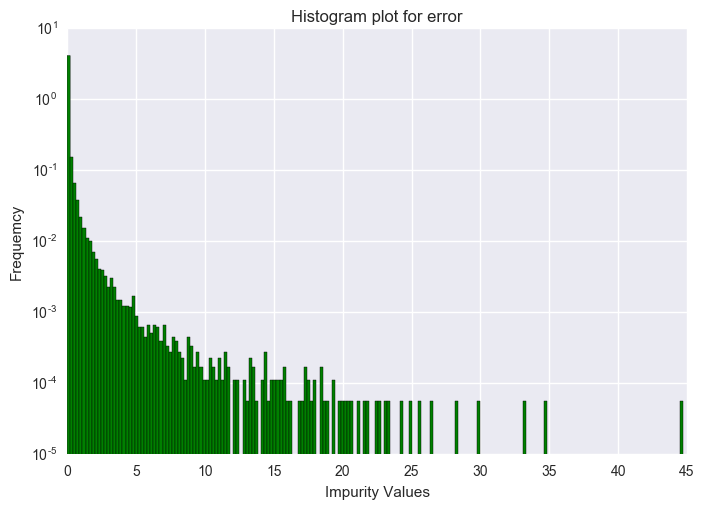

In [125]:
import matplotlib.mlab as mlab

fig, ax = plt.subplots()
plt.hist(errorplot,bins=200,normed=1,facecolor='green')

ax.set_yscale('log')
#ax.set_xscale('log')
plt.title("Histogram plot for error")
plt.ylabel("Frequemcy")
plt.xlabel("Impurity Values")
plt.show()

# Extract Date in the series

In [ ]:
from matplotlib.dates  import  date2num
Data = pd.read_csv('ItemListWithDummy.csv')

In [ ]:
pd.to_datetime(Data.date);

In [ ]:
x_axis = Data['date']

In [ ]:
x_axis = pd.to_datetime(x_axis)

In [55]:
#80000-len(network_output1)

In [56]:
network = np.array(network_output1)

In [57]:
actual= np.array(actual_output1)

In [58]:
actual.shape

(80000, 1, 1)

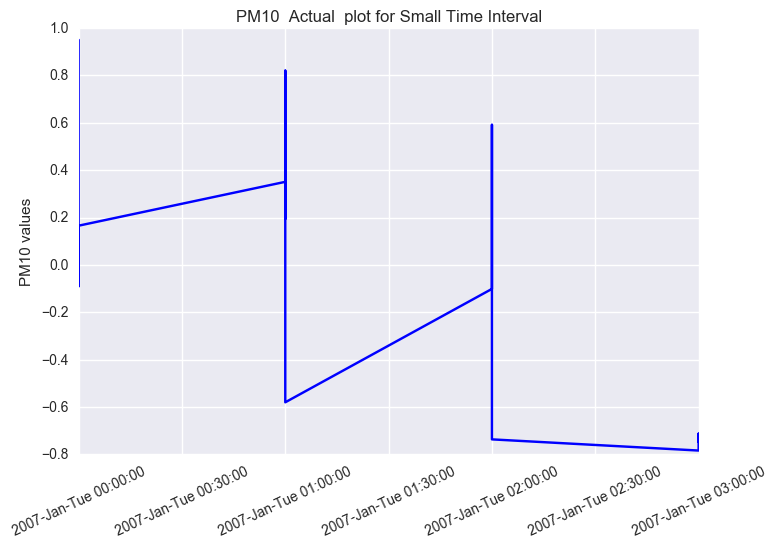

In [59]:
import matplotlib.pyplot 
import matplotlib.dates




fig = plt.figure(figsize=(30, 2))

fig, ax = plt.subplots()
ax.plot_date(x_axis[0:48], actual.reshape(80000,1)[0:48], 'b-')
#ax.xaxis.set_minor_locator(dates.MonthLocator())
#ax.xaxis.set_minor_formatter(dates.DateFormatter('%H:%M:%S'))
#ax.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
#ax.xaxis.grid(True, which="minor")
#ax.yaxis.grid()
#ax.xaxis.set_major_locator(dates.DayLocator())
#ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n%a\%b\%Y'))
ax.xaxis.set_major_formatter( matplotlib.dates.DateFormatter('%Y-%b-%a %H:%M:%S'))
ax.xaxis.grid(True, which="minor")



#ax.xaxis.set_minor_formatter(dates.DateFormatter('\n\n%a\%b\%Y'))


plt.xticks( rotation=25 )
#plt.tight_layout()
plt.ylabel("PM10 values")
plt.title("PM10  Actual  plot for Small Time Interval")
plt.show()

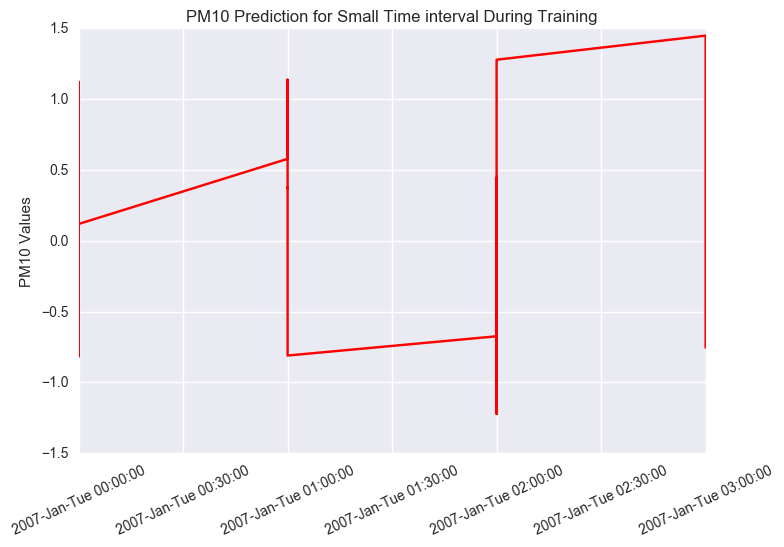

In [60]:
fig = plt.figure(figsize=(30, 2))

fig, ax = plt.subplots()
ax.plot(x_axis[0:48], network.reshape(80000,1)[0:48], 'r-')

#ax.xaxis.set_minor_locator(dates.MonthLocator())
#ax.xaxis.set_minor_formatter(dates.DateFormatter('%H:%M:%S'))
#ax.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
#ax.xaxis.grid(True, which="minor")
#ax.yaxis.grid()
#ax.xaxis.set_major_locator(dates.DayLocator())
#ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n%a\%b\%Y'))
ax.xaxis.set_major_formatter( matplotlib.dates.DateFormatter('%Y-%b-%a %H:%M:%S'))
ax.xaxis.grid(True, which="minor")

#ax.xaxis.set_minor_formatter(dates.DateFormatter('\n\n%a\%b\%Y'))


plt.xticks( rotation=25 )
plt.tight_layout()
plt.ylabel("PM10 Values")
plt.title("PM10 Prediction for Small Time interval During Training")
plt.show()

# Plots predictions during Training

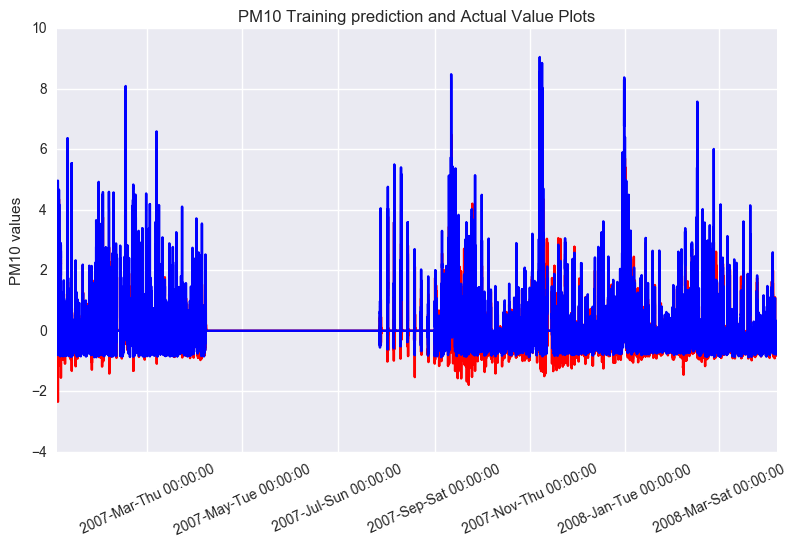

In [61]:
fig = plt.figure(figsize=(30, 2))

fig, ax = plt.subplots()
ax.plot(x_axis[0:80000], network.reshape(80000,1)[0:80000], 'r-')
ax.plot_date(x_axis[0:80000], actual.reshape(80000,1)[0:80000], 'b-')


#ax.xaxis.set_minor_locator(dates.MonthLocator())
#ax.xaxis.set_minor_formatter(dates.DateFormatter('%H:%M:%S'))
#ax.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
#ax.xaxis.grid(True, which="minor")
#ax.yaxis.grid()
#ax.xaxis.set_major_locator(dates.DayLocator())
#ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n%a\%b\%Y'))
ax.xaxis.set_major_formatter( matplotlib.dates.DateFormatter('%Y-%b-%a %H:%M:%S'))
ax.xaxis.grid(True, which="minor")

#ax.xaxis.set_minor_formatter(dates.DateFormatter('\n\n%a\%b\%Y'))


plt.xticks( rotation=25 )
plt.tight_layout()
plt.ylabel("PM10 values")
plt.title("PM10 Training prediction and Actual Value Plots")
plt.show()

# Model Testing

In [1698]:
#Reset counter
counter = 0

In [1699]:
##Testing
 

#Flush LSTM state
sess.run(lstm_state1.assign(tf.zeros([1, lstm_layer1.state_size])))

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]], dtype=float32)

In [1700]:
actual_output_test = []
network_output_test = []

 
for i in range(len(Test_eval[-Remainder:])):
    input_v, output_v = get_pair(Test_eval[-Remainder:])
    _, network_output = sess.run([lstm_update_op1,
                                  final_output],
                                 feed_dict = {
                                     input_layer: input_v,
                                     correct_output: output_v})
        
 
    actual_output_test.append(output_v)
   
    network_output_test.append(network_output)
 


In [1701]:
actual_output_test[-48:];

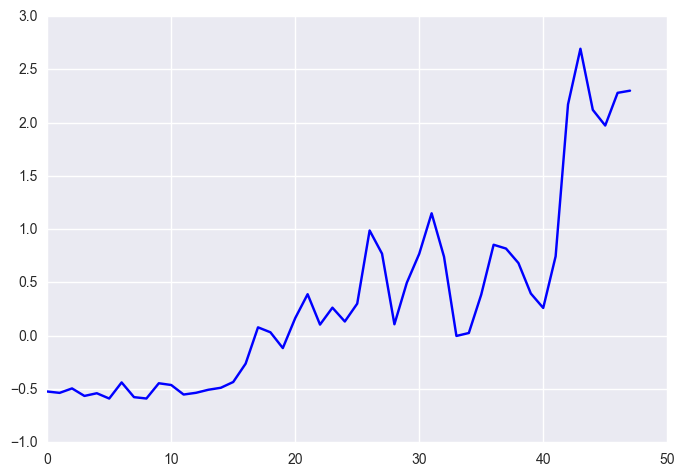

In [1702]:
import matplotlib.pyplot 


fig = plt.figure(figsize=(30, 2))

fig, ax = plt.subplots()
ax.plot( np.array(actual_output_test[-48:]).reshape(48,1), 'b-')
#ax.xaxis.set_minor_locator(dates.MonthLocator())
#ax.xaxis.set_minor_formatter(dates.DateFormatter('%H:%M:%S'))
#ax.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
#ax.xaxis.grid(True, which="minor")
#ax.yaxis.grid()
#ax.xaxis.set_major_locator(dates.DayLocator())
#ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n%a\%b\%Y'))
#ax.xaxis.set_major_formatter(dates.DateFormatter('%Y-%b-%a %H:%M:%S'))
#ax.xaxis.grid(True, which="minor")



#ax.xaxis.set_minor_formatter(dates.DateFormatter('\n\n%a\%b\%Y'))


#plt.xticks( rotation=25 )
#plt.tight_layout()

plt.show()

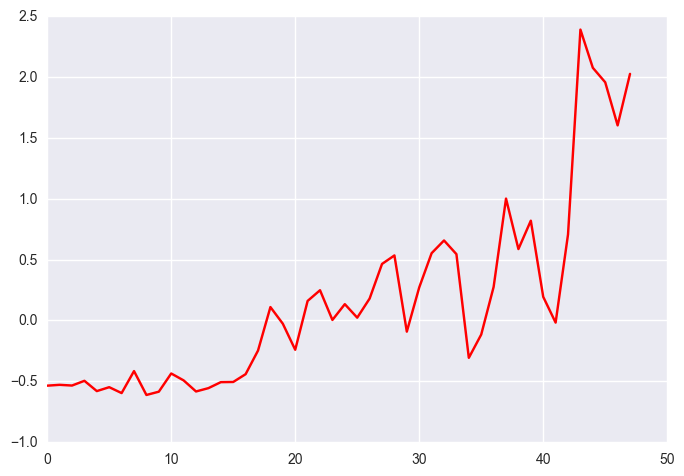

In [1703]:
import matplotlib.pyplot 


fig = plt.figure(figsize=(30, 2))

fig, ax = plt.subplots()
ax.plot( np.array(network_output_test[-48:]).reshape(48,1), 'r-')
#ax.xaxis.set_minor_locator(dates.MonthLocator())
#ax.xaxis.set_minor_formatter(dates.DateFormatter('%H:%M:%S'))
#ax.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
#ax.xaxis.grid(True, which="minor")
#ax.yaxis.grid()
#ax.xaxis.set_major_locator(dates.DayLocator())
#ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n%a\%b\%Y'))
#ax.xaxis.set_major_formatter(dates.DateFormatter('%Y-%b-%a %H:%M:%S'))
#ax.xaxis.grid(True, which="minor")



#ax.xaxis.set_minor_formatter(dates.DateFormatter('\n\n%a\%b\%Y'))


#plt.xticks( rotation=25 )
#plt.tight_layout()

plt.show()

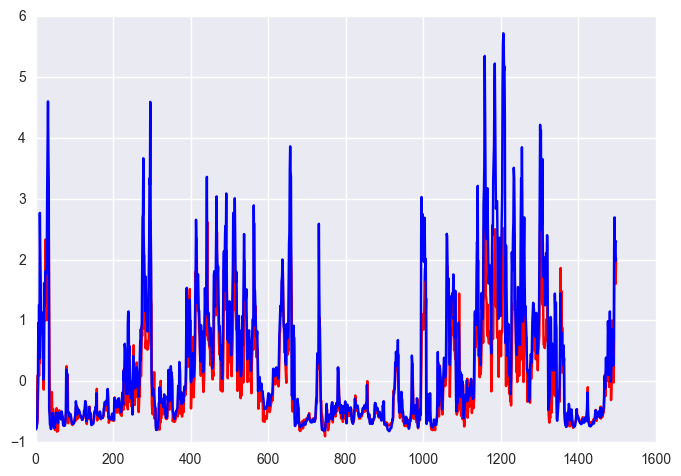

In [1704]:
import matplotlib.pyplot 


fig = plt.figure(figsize=(30, 2))

fig, ax = plt.subplots()
ax.plot( np.array(network_output_test).reshape(len(network_output_test),1), 'r-')
ax.plot( np.array(actual_output_test).reshape(len(actual_output_test),1), 'b-')

#ax.xaxis.set_minor_locator(dates.MonthLocator())
#ax.xaxis.set_minor_formatter(dates.DateFormatter('%H:%M:%S'))
#ax.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
#ax.xaxis.grid(True, which="minor")
#ax.yaxis.grid()
#ax.xaxis.set_major_locator(dates.DayLocator())
#ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n%a\%b\%Y'))
#ax.xaxis.set_major_formatter(dates.DateFormatter('%Y-%b-%a %H:%M:%S'))
#ax.xaxis.grid(True, which="minor")



#ax.xaxis.set_minor_formatter(dates.DateFormatter('\n\n%a\%b\%Y'))


#plt.xticks( rotation=25 )
#plt.tight_layout()

plt.show()

In [1786]:
from scipy.interpolate import interp1d


In [1787]:
xn_ax = np.linspace(0,48,48*2)



In [1788]:
x_ax = np.linspace(0,50,48)
y_cor=np.array(network_output_test[-48:]).reshape(48,1)

In [1789]:
y_cor=np.reshape(y_cor,(48))

In [1790]:
# new x values
xn_ax = np.linspace(1,48,48*10)
 
# new y values
yn_cor = interp1d(x_ax,y_cor, kind='cubic')

<function matplotlib.pyplot.show>

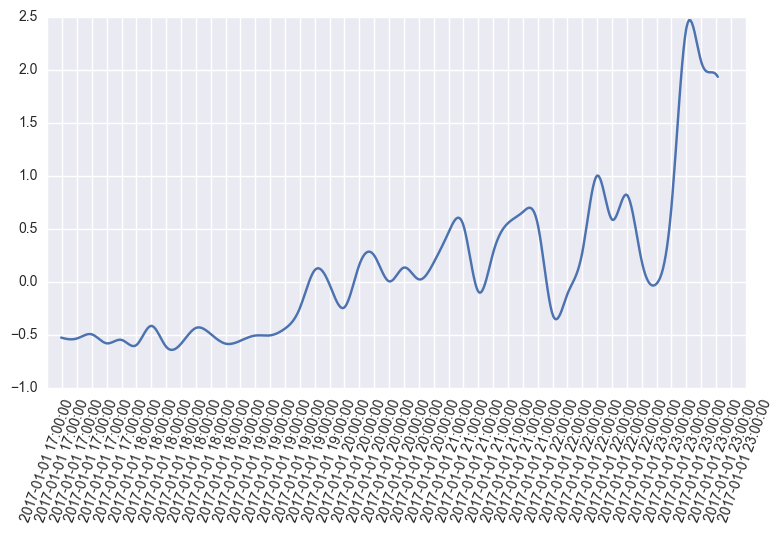

In [1791]:
plt.plot(xn_ax, yn_cor(xn_ax))
plt.xticks(x_ax, x_axis[-48:], size='small', rotation=70)
plt.tight_layout()
plt.show

In [172]:
actual_output_test = np.array(actual_output_test)

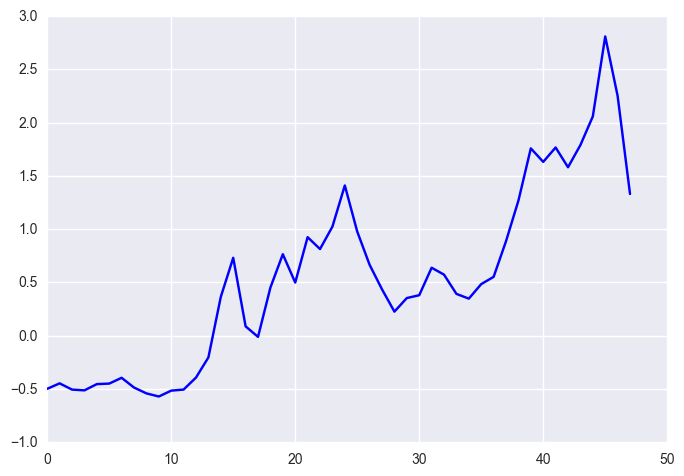

In [173]:
import matplotlib.pyplot 


fig = plt.figure(figsize=(30, 2))

fig, ax = plt.subplots()
ax.plot( actual_output_test.reshape(48,1), 'b-')
#ax.xaxis.set_minor_locator(dates.MonthLocator())
#ax.xaxis.set_minor_formatter(dates.DateFormatter('%H:%M:%S'))
#ax.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
#ax.xaxis.grid(True, which="minor")
#ax.yaxis.grid()
#ax.xaxis.set_major_locator(dates.DayLocator())
#ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n%a\%b\%Y'))
#ax.xaxis.set_major_formatter(dates.DateFormatter('%Y-%b-%a %H:%M:%S'))
#ax.xaxis.grid(True, which="minor")



#ax.xaxis.set_minor_formatter(dates.DateFormatter('\n\n%a\%b\%Y'))


#plt.xticks( rotation=25 )
#plt.tight_layout()

plt.show()

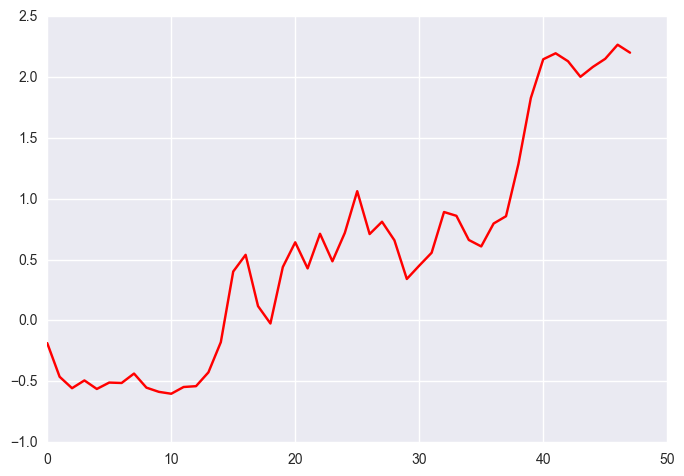

In [174]:
import matplotlib.pyplot 


fig = plt.figure(figsize=(30, 2))

fig, ax = plt.subplots()
ax.plot( network_output_test.reshape(48,1), 'r-')
#ax.xaxis.set_minor_locator(dates.MonthLocator())
#ax.xaxis.set_minor_formatter(dates.DateFormatter('%H:%M:%S'))
#ax.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
#ax.xaxis.grid(True, which="minor")
#ax.yaxis.grid()
#ax.xaxis.set_major_locator(dates.DayLocator())
#ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n%a\%b\%Y'))
#ax.xaxis.set_major_formatter(dates.DateFormatter('%Y-%b-%a %H:%M:%S'))
#ax.xaxis.grid(True, which="minor")



#ax.xaxis.set_minor_formatter(dates.DateFormatter('\n\n%a\%b\%Y'))


#plt.xticks( rotation=25 )
#plt.tight_layout()

plt.show()